In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                                    Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.2.4-tf
2.0.0


In [2]:
flu_df = pd.read_csv('../data/clean_flu_data.csv').sort_values('date')
print(flu_df.shape)

(461, 51)


In [3]:
state = 'Texas'
df_state_train = pd.read_csv('../data/state_flu_google/train/' +state+ '.csv')
df_state_test = pd.read_csv('../data/state_flu_google/test/' +state+ '.csv')
print(df_state_train.shape)
print(df_state_test.shape)

df_state_train = pd.merge(flu_df.drop(state,1), df_state_train, on = 'date', how = 'inner')
df_state_test = pd.merge(flu_df.drop(state,1), df_state_test, on = 'date', how = 'inner')
print(df_state_train.shape)
print(df_state_test.shape)

(368, 99)
(92, 99)
(368, 148)
(92, 148)


In [29]:
target = 'target'
y_train = df_state_train[target].values
y_test = df_state_test[target].values

predictors = df_state_train.columns.difference([target, 'date'])
X_train = df_state_train[predictors].values
X_test = df_state_test[predictors].values

X_all = np.vstack((X_train, X_test))
y_all = np.concatenate((y_train, y_test))

# Random Forest

In [7]:
rf = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf.predict(X_test)

def plot_predictions(y_test, y_pred):
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    plt.plot(y_test, c='g', label = 'y_test')
    plt.plot(y_pred, c='orange', ls='--', label = 'y_pred')
    plt.legend()
    plt.xticks = df_state_test['date']

Test RMSE:  1.6707584512064555


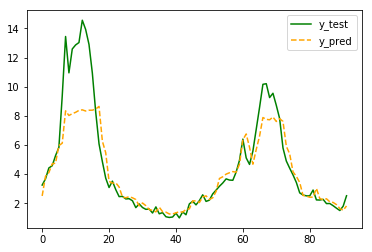

In [8]:
plot_predictions(y_test, y_pred)

# Vanilla NN

In [51]:
def NN(X_train,y_train,batch_size,epochs,verbose):
    n_units = 64
    drop_rate = .1
    optimizer = "rmsprop"
    loss = "mse"
    batch_size = batch_size
    epochs = epochs
    validation_split = 0.1
    verbose = verbose
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(input_dim=(X_train.shape[1]),units = n_units,activation = 'relu'))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(units = n_units,activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                validation_split=validation_split, verbose=verbose)
    return model

Train on 331 samples, validate on 37 samples
Epoch 1/20
331/331 [==============================] - 1s 2ms/sample - loss: 10.2987 - val_loss: 5.6191
Epoch 2/20
331/331 [==============================] - 0s 133us/sample - loss: 5.0401 - val_loss: 2.8144
Epoch 3/20
331/331 [==============================] - 0s 141us/sample - loss: 3.0635 - val_loss: 1.9822
Epoch 4/20
331/331 [==============================] - 0s 146us/sample - loss: 2.7924 - val_loss: 2.1872
Epoch 5/20
331/331 [==============================] - 0s 146us/sample - loss: 2.4125 - val_loss: 1.4443
Epoch 6/20
331/331 [==============================] - 0s 175us/sample - loss: 2.1896 - val_loss: 2.8734
Epoch 7/20
331/331 [==============================] - 0s 143us/sample - loss: 2.1215 - val_loss: 1.3489
Epoch 8/20
331/331 [==============================] - 0s 150us/sample - loss: 1.9557 - val_loss: 1.8129
Epoch 9/20
331/331 [==============================] - 0s 142us/sample - loss: 1.8559 - val_loss: 1.8801
Epoch 10/20
331/331 

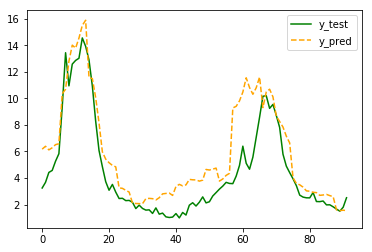

In [52]:
model = NN(X_train, y_train,32,20,1)
y_pred = model.predict(X_test)
plot_predictions(y_test, y_pred)

Test RMSE:  2.5651577371135224


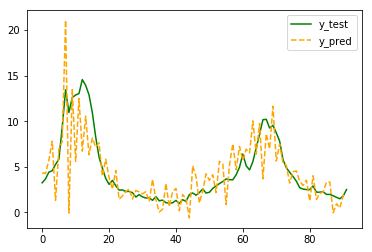

In [68]:
size = len(X_train)
max_train_size = size
y_pred = []

for t in range(len(y_test)):
    X_train_temp, X_test_temp = X_all[size+t-max_train_size:size+t], X_all[size+t:]
    y_train_temp = y_all[size+t-max_train_size:size+t]
    nn = NN(X_train_temp, y_train_temp,32,10,0)
    pred = nn.predict(X_test_temp)
    y_pred.append(pred[0])
    
plot_predictions(y_test, y_pred)

In [ ]:
# optimizer = "rmsprop"
# loss = "mae"

# n_steps, n_features = X_train.shape[0], X_train.shape[1]
# n_units = 64
# batch_size = 32
# epochs = 10
# validation_split = 0.2
# verbose = 1

# model = Sequential()
# model.add(SimpleRNN(n_units, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1, activation='relu'))
          
# # Compile model
# model.compile(optimizer=optimizer, loss=loss)
# print(model.summary())

# # Train model
# history = model.fit(X_train.reshape(1,X_train.shape[0],X_train.shape[1]),
#                     y_train.reshape(1,y_train.shape[0]),
#                     batch_size=batch_size, epochs=epochs, 
#                     validation_split=validation_split, verbose=verbose)